## Basics of Fitting a Differential Equation to Data

#### Benjamin Whipple, 04/23/24, University of Idaho

### Background

**Model Calibration -** Model calibration is a key step for the investigation and application of mathematical models. Model calibration -also called fitting, training, or estimation in different disciplines-involves fine-tuning model parameters to ensure that the model outputs align closely with observed data. Model calibration involves six key components: the data, the model, the parameters, the loss function, the optimizer, and the parameter bounds. Broadly, calibration involves minimizing the loss function, which quantifies the degree to which the model fails to match the data given a specific parameter vector. The result of the calibration process is a parameter vector for which a given model most effectively matches the given data. We proceed to describe each step of the calibration process below.

**Step 1: Choosing Parameter Bounds -** We begin by assuming that we have data and a candidate model for the data and that the model is parameterized by a parameter vector $\theta$. We should first investigate a search domain $\Theta$ such that $\theta \in \Theta$. In practice, this means reviewing the literature to identify previous estimates of the parameter, and then choosing to fix specific $\theta_i \in \theta$ to those estimates, or choosing intervals $[a_i,b_i]$ for each parameter $\theta_i$ which are reasonable from the existing theory. Choosing small intervals will improve the performance of most optimization algorithms, but choosing too small of intervals risks excluding the most appropriate parameter values $\theta_i$.

**Step 2: Formulating the Loss Function -** Given the data, candidate model, and parameter bounds, we need to formulate the loss function. The loss function $L$ relates model predictions $\hat{y}$ to measured data $y$, and is increasing with respect to the distance between predictions and data $\|y-\hat{y}\|$. A common choice of loss function $L$ is the mean squared error (MSE), presented below.
$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{R} \sum_{j=1}^{T} w_k\sum_{k=1}^{S} (y_{ijk} - \hat{y}_{ijk})^2
$$
Our formulation of MSE allows for consideration of multiple time points $j$, multiple measured states $k$, and multiple replicates $i$. 

Note that we also incorporate $w_k > 0$ as a weighting hyperparameter for the loss function. In some problems, weighting different states higher can lead to better performance from the optimizers. The choice of weights is entirely a practical choice which can be chosen by hyperparameter search (look it up if interested) or by trial and error. The choice of weights does not theoretically change the result of the optimization.

**Step 3: Choosing the Optimizer -** There are many different optimizers which are useful for minimizing the loss function, though we have restricted ourselves to considering only constrained optimization algorithms-as we assume the parameter values are bounded inside $\Theta$. Many optimization frameworks allow for nearly drop-in replacement of the chosen optimizer, so we consider the precise choice somewhat unimportant. However, we note that in the case of calibrating differential equation models, metaheuristics - a class of algorithms which generally yield good, but not optimal solutions, often outperform more traditional algorithms such as the various of quasi-newton methods.

**Step 4: Performing the Optimization -** We use the differential evolution algorithm to calibrate our differential equation model. One downside of using metaheuristics such as differential evolution is that they typically take a relatively large amount of time to run, though they are less prone to being trapped in a local minima than gradient based methods.

**Step 5: Diagnostics -** After calibrating the model, it is important to conduct diagnostics on the result. Frequently, the first step is to visualize the calibrated model near the data to assess goodness of fit. Further steps may be to conduct local sensitivity analysis or practical identifiability analysis of the model parameters.

### Example: Classical Lotka-Volterra Model

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
import time

In [2]:
def lotka_volterra(y, t, params):
    prey, predator = y
    alpha, beta, gamma, delta = params
    dydt = [alpha * prey - beta * prey * predator,
            delta * prey * predator - gamma * predator]
    return dydt

In [11]:
# True parameters
params_true = [0.6, 0.1, 0.8, 0.05]
y0 = [40, 9]  # Initial conditions: [prey, predator]
t = np.linspace(0, 15, 16)  # Time points

# Generate data
data = odeint(lotka_volterra, y0, t, args=(params_true,))
data += np.random.normal(size=data.shape) * 2.0  # Add noise


In [23]:
def objective(params):
    # Integrate Lotka-Volterra equations with current params
    solution = odeint(lotka_volterra, y0, t, args=(params,))
    # Calculate MSE between observed data and model prediction
    # This would be changed if you had multiple replicates
    mse = np.mean((data - solution)**2)
    return mse


In [21]:
# Bounds for each parameter. These are chosen arbitrarily as an example. 
# It is an exercise to choose appropriate parameter bounds for your problem.
bounds = [(0, 1), (0, 0.2), (0, 1), (0, 0.1)]

# Differential evolution optimization
start = time.time()
result = differential_evolution(objective, bounds, strategy='best1bin',
                                maxiter=1000, popsize=15, tol=0.01,
                                mutation=(0.5, 1), recombination=0.7)
end = time.time()
print("Optimal parameters found:", result.x)
print(f"Time taken {end-start} seconds")

Optimal parameters found: [0.59830409 0.09345741 0.83268393 0.05372737]
Time taken 3.1591010093688965 seconds


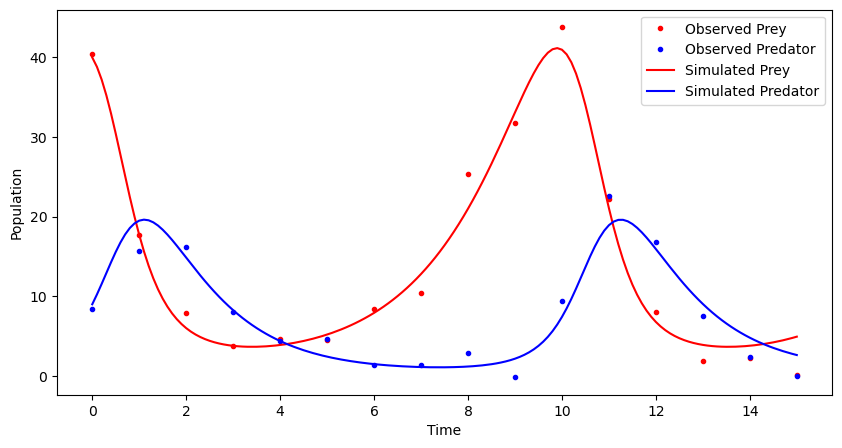

In [22]:
# Use the optimal parameters to simulate the model
optimal_params = result.x
ts = np.linspace(0,15,151)
simulated = odeint(lotka_volterra, y0, ts, args=(optimal_params,))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, data[:, 0], 'r.', label='Observed Prey')
plt.plot(t, data[:, 1], 'b.', label='Observed Predator')
plt.plot(ts, simulated[:, 0], 'r-', label='Simulated Prey')
plt.plot(ts, simulated[:, 1], 'b-', label='Simulated Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()
